In [14]:
# %%capture --no-stderr
# %pip install -U langgraph transformers langsmith langchain-huggingface

ERROR: Could not find a version that satisfies the requirement langchain-nvidia (from versions: none)
ERROR: No matching distribution found for langchain-nvidia
Note: you may need to restart the kernel to use updated packages.


In [11]:
import getpass
import os
from langchain_nvidia import ChatNVIDIA


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("NVIDIA_API_KEY")

NVIDIA_API_KEY: ········


In [12]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [13]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [ ]:
import json
from pathlib import Path
from langchain.docstore.document import Document

def load_documents_from_json(directory_path):
    documents = []
    for file_path in Path(directory_path).glob("*.json"):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                content = json.load(f)
                text = content.get("text", "")
                metadata = content.get("metadata", {})
                if text.strip():
                    documents.append(Document(page_content=text, metadata=metadata))
            except Exception as e:
                print(f"Failed to load {file_path.name}: {e}")
    return documents

In [14]:
from langchain_core.messages import AIMessage

llm = ChatNVIDIA(base_url="https://integrate.api.nvidia.com/v1", model="meta/llama-3.3-70b-instruct")
def check_relevance_node(state):
    user_question = state["user_input"]
    docs = state["docs"]  # dict of key -> content

    relevant_docs = {}

    for key, content in docs.items():
        prompt = f"""
Question or email:
"{user_question}"

Document content:
{content}

Does this content answer the question directly?
Respond with your clear justification first, followed by "YES" or "NO" only on the last line.
If absolutely uncertain, respond "NO". If slightly certain, respond "YES"
"""
        try:
            resp = llm.invoke(prompt)  # returns AIMessage
            answer = resp.content.strip()

            # Debugging the response and reasoning
            print(f"Prompt:\n{prompt}")
            print(f"LLM Answer: {answer}")

            # Check if the answer is YES or NO and act accordingly
            last_line = answer.split('\n')[-1].strip().upper()
            if last_line == "YES":
                relevant_docs[key] = content
                print(f"Document '{key}' is relevant!")
            else:
                print(f"Document '{key}' is not relevant.")

        except Exception as e:
            print(f"[Error] {key} relevance check failed:", e)

    # Store the relevant docs in the state for further use
    state["relevant_docs"] = relevant_docs
    print(f"Checked {len(docs)} docs. Found {len(relevant_docs)} relevant.")
    return state


/Users/adityavinodh/anaconda3/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:212: UserWarning: Found meta/llama-3.3-70b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [15]:
from langchain_core.messages import AIMessage

llm = ChatNVIDIA(base_url="https://integrate.api.nvidia.com/v1", model="meta/llama-3.3-70b-instruct")

def build_prompt_node(state):
    user_question = state["user_input"]
    relevant_docs = state.get("relevant_docs", {})

    if not relevant_docs:
        print("No relevant documents found. Skipping final prompt generation.")
        state["final_response"] = "Sorry, I couldn't find a relevant answer in the provided documents."
        return state

    combined_context = "\n\n---\n\n".join(
        f"Document {i+1}:\n{content}" for i, content in enumerate(relevant_docs.values())
    )

    final_prompt = f"""
You are an intelligent assistant.

Here is a question from the user:
"{user_question}"

Here are relevant pieces of context from various documents:
{combined_context}

Based on the above content, provide a complete and helpful answer to the user's question.
Be as specific and concise. If the content is not enough, say so clearly.
"""

    try:
        response = llm.invoke(final_prompt)
        final_answer = response.content.strip()
        state["final_response"] = final_answer
    except Exception as e:
        print("[Error] Failed to generate final response:", e)
        state["final_response"] = "An error occurred while generating the answer."

    return state


/Users/adityavinodh/anaconda3/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:212: UserWarning: Found meta/llama-3.3-70b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [16]:
def generate_answer_node(state):
    final_answer = state.get("final_response", None)

    if not final_answer:
        print("No final response available to return.")
        state["answer"] = "Sorry, I couldn't generate an answer at this time."
    else:
        state["answer"] = final_answer

    return state


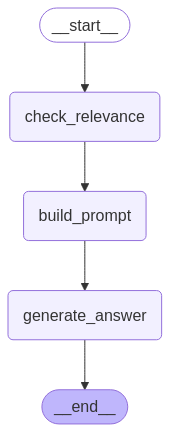

In [17]:
from langgraph.graph import StateGraph

builder = StateGraph(State)

builder.add_node("check_relevance", check_relevance_node)
builder.add_node("build_prompt", build_prompt_node)
builder.add_node("generate_answer", generate_answer_node)

builder.set_entry_point("check_relevance")
builder.add_edge("check_relevance", "build_prompt")
builder.add_edge("build_prompt", "generate_answer")

builder.set_finish_point("generate_answer")

graph = builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
# Dummy data for testing
user_input = "How can I engage with industry partners through Cornell's research services?"

docs = {
    "doc1": {
        "URL location": "https://researchservices.cornell.edu/commercialize/engaging-companies",
        "Last modification date": "2023-04-05T19:25Z",
        "Change frequency": "yearly",
        "Priority": "0.5",
        "Scraped Text": """Find guidance on funding and agency updates during the federal government transition(updated 3/19/2025) (/federal-transition)
Essential ToolsFind My GCORASSExternalInstitutional Profile & DUNSIACUC applications (Cayuse Animal Management)Find Your Next Funding OpportunityIBC Applications (RASS-IBC)Research Development (ReD) ServicesIRB Applications (RASS-IRB)ExternalRates and budgetsReport external interests (RASS-COI)Join List ServsRASS Access Request FormAsk EHSExternalWeb Financials (WebFin2)ExternalCornell Data ServicesExternalPI DashboardExternalTravel RegistryExternalResearch Financials (formerly RA Dashboard)ExternalInternational research activitiesExternalRegister for Federal and Non-Federal SystemsDisclose Foreign Collaborations and SupportResearch metrics & executive dashboardsTraining (/about/essential-tools, /gco, http://guide.rass.cornell.edu/, /resources/institutional-profile-duns-and-uei-numbers, /resources/submit-new-iacuc-protocol, /proposal/Find-Your-Next-Funding-Opportunity, /resources/ibc-application-submission-review-and-approval, /research-development, https://rass.cornell.edu/irb, /proposal/budget, /compliance/conflict-of-interest, /resources/research-mailing-lists-list-servs, /resources/get-access-financial-sponsored-projects-data, https://tdx.cornell.edu/TDClient/42/Portal/Requests/TicketRequests/NewForm?ID=q5sab44D6GI_, http://webfin2.cornell.edu/, https://data.research.cornell.edu/, https://pidash.cornell.edu, https://travelregistry.cornell.edu/, http://radash.cornell.edu/, https://navigate.cornell.edu, /resources/register-federal-and-non-federal-systems, /proposal/disclose-foreign-collaborations-and-support, /resources/research-metrics, /training)
Find My GCO (/gco)
RASSExternal (http://guide.rass.cornell.edu/)
Institutional Profile & DUNS (/resources/institutional-profile-duns-and-uei-numbers)
IACUC applications (Cayuse Animal Management) (/resources/submit-new-iacuc-protocol)
Find Your Next Funding Opportunity (/proposal/Find-Your-Next-Funding-Opportunity)
IBC Applications (RASS-IBC) (/resources/ibc-application-submission-review-and-approval)
Research Development (ReD) Services (/research-development)
IRB Applications (RASS-IRB)External (https://rass.cornell.edu/irb)
Rates and budgets (/proposal/budget)
Report external interests (RASS-COI) (/compliance/conflict-of-interest)
Join List Servs (/resources/research-mailing-lists-list-servs)
RASS Access Request Form (/resources/get-access-financial-sponsored-projects-data)
Ask EHSExternal (https://tdx.cornell.edu/TDClient/42/Portal/Requests/TicketRequests/NewForm?ID=q5sab44D6GI_)
Web Financials (WebFin2)External (http://webfin2.cornell.edu/)
Cornell Data ServicesExternal (https://data.research.cornell.edu/)
PI DashboardExternal (https://pidash.cornell.edu)
Travel RegistryExternal (https://travelregistry.cornell.edu/)
Research Financials (formerly RA Dashboard)External (http://radash.cornell.edu/)
International research activitiesExternal (https://navigate.cornell.edu)
Register for Federal and Non-Federal Systems (/resources/register-federal-and-non-federal-systems)
Disclose Foreign Collaborations and Support (/proposal/disclose-foreign-collaborations-and-support)
Research metrics & executive dashboards (/resources/research-metrics)
Training (/training)
Search (/search)
Engaging with Industry
Hundreds of corporations have learned that partnering with Cornell is smart business. With a dynamic campus in Ithaca and the development of Cornell Tech in New York City, Cornell fosters a climate where collaboration with industry flourishes, creating breakthrough discoveries that help to advance industry and expanding opportunities for continuous innovation.
Office of Corporate Engagement
TheOffice of Corporate Engagementtracks, leads and grows university strategic corporate relationships. Provides support to grow lab-to-market pathways through grants, centers and innovation hubs. Serves to assist faculty in building lasting corporate research partnerships. Helps companies connect with Cornell via campus outreach staff. (/offices/office-corporate-engagement)
Licensing Strategy
Over the years, theCenter for Technology Licensing (CTL)has licensed technologies to industry partners and start-ups all over the world in support of Cornell’s mission and to develop these technologies and plant varieties into products and services for public good. Once you have disclosed your invention to CTL, your licensing officer will work with you to explore its market or commercial potential and develop a licensing strategy. (https://ctl.cornell.edu/)
If you and your licensing officer determine the use of your invention in the starting of a new business enterprise will best advance the university’s missions and strategic goals, CTL will work to help create the startup company. If you are interested in leading this effort, let the licensing officer responsible for your invention know. (https://ctl.cornell.edu/about/staff/#commercialization)
Corporate Partnership & Innovation (/commercialize)
Quick Reference
Rates (/rates)
Forms (/forms)
Policies (/policies)
Contacts (/contacts)
Training (/training)
Events (/events)
News & Announcements (/news)
© 2019 Cornell University
Web Accessibility Help (mailto:rais-help@cornell.edu?subject=researchservices.cornell.edu%20site)
"""
    }
}
        
# Simulate initial state
state = {
    "user_input": user_input,
    "docs": docs
}

# Step 1: Relevance Filtering
state = check_relevance_node(state)

# Step 2: Build Prompt
state = build_prompt_node(state)

# Step 3: Generate Final Answer
state = generate_answer_node(state)

# See output
print("\n=== Final Answer ===\n")
print(state["answer"])


Prompt:

Question or email:
"Who am I?"

Document content:
{'URL location': 'https://researchservices.cornell.edu/commercialize/engaging-companies', 'Last modification date': '2023-04-05T19:25Z', 'Change frequency': 'yearly', 'Priority': '0.5', 'Scraped Text': 'Find guidance on funding and agency updates during the federal government transition(updated 3/19/2025) (/federal-transition)\nEssential ToolsFind My GCORASSExternalInstitutional Profile & DUNSIACUC applications (Cayuse Animal Management)Find Your Next Funding OpportunityIBC Applications (RASS-IBC)Research Development (ReD) ServicesIRB Applications (RASS-IRB)ExternalRates and budgetsReport external interests (RASS-COI)Join List ServsRASS Access Request FormAsk EHSExternalWeb Financials (WebFin2)ExternalCornell Data ServicesExternalPI DashboardExternalTravel RegistryExternalResearch Financials (formerly RA Dashboard)ExternalInternational research activitiesExternalRegister for Federal and Non-Federal SystemsDisclose Foreign Colla